In [3]:
import serial
import time
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt

# import matplotlib as mpl


port = '/dev/tty.usbmodem144050001' #131357501
ser = serial.Serial(port, 115200)

# pinch pressure

In [ ]:
def analyze_txt_and_predict_force(model_file_path, write_file_name, write_file_path_root, frame_interval, window_size, force_threshold):
    if frame_interval <= window_size:
        return analyze_txt_and_predict_force_overlap(model_file_path, write_file_name, write_file_path_root, frame_interval, window_size, force_threshold)
    else:
        return analyze_txt_and_predict_force_nonOverlap(model_file_path, write_file_name, write_file_path_root, frame_interval, window_size, force_threshold)
def analyze_txt_and_predict_force_overlap(model_file_path, write_file_name, write_file_path_root, frame_interval, window_size, force_threshold):
    def normalize(raw_data):
        mean = np.mean(raw_data, axis=0)
        std = np.std(raw_data, axis=0)
        normalized_data = (raw_data - mean) / (std + 1e-6)
        return normalized_data
    model = joblib.load(model_file_path)

    # Temporary lists to hold data before packing into the main lists (as a queue)
    temp_real_queue = []
    temp_imaginary_queue = []
    temp_force_queue = []

    y_test = []
    y_pred = []
    x_test_list = []
    x_test_list_preNormalize = []
    if not os.path.exists(write_file_path_root):
        os.makedirs(write_file_path_root)
    write_file_path = os.path.join(write_file_path_root, write_file_name)
    with open(write_file_path, 'w') as f:
        # with open(read_file_path, 'r') as file:
        while True:
                frame_count = 0  # To track the total number of frames processed
                extracting_frames = False  # Flag to indicate if we are in an extraction block
                lines_in_frame = 0  # To count lines within a frame block
                predict_size = 0

                line = ser.readline().decode()
                line = line.strip()

                # Detect the start of a new frame
                if line == "frame":
                    frame_count += 1
                    lines_in_frame = 0  # Reset line count for the new frame
                    extracting_frames = True  # Always extracting frames

                # If we're extracting frames, process the next 3 lines
                if extracting_frames:
                    if lines_in_frame == 1:  # First data line (real values)
                        temp_real_queue.append([float(num) for num in line.split()])
                    elif lines_in_frame == 2:  # Second data line (imaginary values)
                        temp_imaginary_queue.append([float(num) for num in line.split()])
                    elif lines_in_frame == 3:  # Third data line (force values)
                        force_value = float(line.split()[0])  # Extract the first value (force)
                        temp_force_queue.append(force_value)

                        # If the queue length reaches frames_to_extract, perform prediction
                        if len(temp_real_queue) == window_size:
                            # Convert queue data to numpy arrays
                            np_real_list = np.array(temp_real_queue)
                            np_imaginary_list = np.array(temp_imaginary_queue)
                            np_force_list = np.array(temp_force_queue)
                            np_force_mean_value = np.mean(np_force_list)
                            if np_force_mean_value < force_threshold:
                                np_force_mean_value = 0
                            # Combine real and imaginary parts
                            combined_12 = np.concatenate((np_real_list, np_imaginary_list), axis=1)
                            # combined_12 = np.expand_dims(combined_12, axis=0)
                            x_test_list_preNormalize.append(combined_12)
                            # combined_12 = normalize(combined_12)
                            x_test_list.append(combined_12)
                            X_test = combined_12.reshape(1, window_size * 12)
                            # Perform prediction
                            predictions = model.predict(X_test)
                            predict_size += 1

                            y_pred.append(predictions[0])
                            y_test.append(np_force_mean_value)
                            # Write results to file
                            f.write(f"Predict {predict_size}: \n")
                            f.write(f"{np_force_mean_value}\n")
                            f.write(f"{predictions[0]}\n")

                            # Remove the oldest frame to allow overlap
                            for delete in range(frame_interval):
                                temp_real_queue.pop(0)
                                temp_imaginary_queue.pop(0)
                                temp_force_queue.pop(0)

                # Count lines within a frame block
                if extracting_frames:
                    lines_in_frame += 1
        ser.close()
    f.close()
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    y_pred_write_file_path = os.path.join(write_file_path_root, "y_pred")
    np.save(y_pred_write_file_path, y_pred)
    y_test_write_file_path = os.path.join(write_file_path_root, "y_test")
    np.save(y_test_write_file_path, y_test)
    return y_pred, y_test, np.array(x_test_list), np.array(x_test_list_preNormalize)
def analyze_txt_and_predict_force_nonOverlap(model_file_path, write_file_name, write_file_path_root, frame_interval, window_size, force_threshold):
    def normalize(raw_data):
        mean = np.mean(raw_data, axis=0)
        std = np.std(raw_data, axis=0)
        normalized_data = (raw_data - mean) / (std + 1e-6)
        return normalized_data
    model = joblib.load(model_file_path)
    y_test = []
    y_pred = []
    x_test_list = []
    x_test_list_preNormalize = []
    if not os.path.exists(write_file_path_root):
        os.makedirs(write_file_path_root)
    write_file_path = os.path.join(write_file_path_root, write_file_name)
    with open(write_file_path, 'w') as f:
        frame_count = 0  # To track the total number of frames processed
        extracting_frames = False  # Flag to indicate if we are in an extraction block
        lines_in_frame = 0  # To count lines within a frame block
        predict_size = 0
        while True:
        # with open(read_file_path, 'r') as file:
            # for line in file:
                line = ser.readline().decode()
                line = line.strip()

                # Detect the start of a new frame
                if line == "frame":
                    frame_count += 1
                    lines_in_frame = 0  # Reset line count for the new frame

                    # Check if it's time to start extracting frames
                    if frame_count % frame_interval == 0:
                        extracting_frames = True
                        frames_extracted = 0  # Reset the number of extracted frames for this block
                        temp_real_list = []  # Clear temp lists for this extraction block
                        temp_imaginary_list = []
                        temp_force_list = []

                # If we're extracting frames, process the next 3 lines
                if extracting_frames:
                    if lines_in_frame == 1:  # First data line (real values)
                        temp_real_list.append([float(num) for num in line.split()])
                    elif lines_in_frame == 2:  # Second data line (imaginary values)
                        temp_imaginary_list.append([float(num) for num in line.split()])
                    elif lines_in_frame == 3:  # Third data line (force values)
                        force_value = float(line.split()[0])  # Extract the first value (force)
                        temp_force_list.append(force_value)
                        frames_extracted += 1  # Increment frames extracted count


                        # If we have extracted enough frames (frames_to_extract), store them
                        if frames_extracted == window_size:
                            # Convert queue data to numpy arrays
                            np_real_list = np.array(temp_real_list)
                            np_imaginary_list = np.array(temp_imaginary_list)
                            np_force_list = np.array(temp_force_list)
                            np_force_mean_value = np.mean(np_force_list)
                            if np_force_mean_value < force_threshold:
                                np_force_mean_value = 0
                            # Combine real and imaginary parts
                            combined_12 = np.concatenate((np_real_list, np_imaginary_list), axis=1)
                            # combined_12 = np.expand_dims(combined_12, axis=0)
                            x_test_list_preNormalize.append(combined_12)
                            # combined_12 = normalize(combined_12)
                            x_test_list.append(combined_12)
                            X_test = combined_12.reshape(1, window_size * 12)
                            # Perform prediction
                            predictions = model.predict(X_test)
                            predict_size += 1

                            y_pred.append(predictions[0])
                            y_test.append(np_force_mean_value)
                            # Write results to file
                            f.write(f"Predict {predict_size}: \n")
                            f.write(f"{np_force_mean_value}\n")
                            f.write(f"{predictions[0]}\n")
                            extracting_frames = False  # Stop extracting for this interval

                # Count lines within a frame block
                if extracting_frames:
                    lines_in_frame += 1
        ser.close()
    f.close()
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    y_pred_write_file_path = os.path.join(write_file_path_root, "y_pred")
    np.save(y_pred_write_file_path, y_pred)
    y_test_write_file_path = os.path.join(write_file_path_root, "y_test")
    np.save(y_test_write_file_path, y_test)
    return y_pred, y_test, np.array(x_test_list), np.array(x_test_list_preNormalize)

model_file_path = '/home/ubuntu/paper_arm_model/best_model/best_rf_model.joblib'
write_file_name = "predict_result_and_ground_truth.txt"
write_file_path_root = "/home/ubuntu/paper_arm_model/best_model_result/test3"
frame_interval = 500  # Number of frames to skip between extractions
window_size = 10  # Number of frames to extract after the interval
force_threshold = 0.5

y_pred, y_test, x_test_list, x_test_list_preNormalize = analyze_txt_and_predict_force(model_file_path, write_file_name, write_file_path_root, frame_interval, window_size, force_threshold)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)
print(r2)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='y_test (Ground Truth)', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='y_pred (Prediction)', marker='x', linestyle='--', color='red')


plt.title('Comparison of y_test and y_pred')
plt.xlabel('Index')
plt.ylabel('Values')


plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()


# Predict Processed Data

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import glob
is_windowed = True #@param{type: "boolean"}
window_size = 10 #@param
is_normalization = True #@param{type: "boolean"}
def normalize(raw_data):

  mean = np.mean(raw_data, axis=0)
  std = np.std(raw_data, axis=0)
  normalized_data = (raw_data - mean) / (std + 1e-6)
  return normalized_data

# Function to create windowed data
def create_windowed_data(X, y, window_size=10):
    num_samples = X.shape[0] - window_size + 1  # Number of windows we can create
    windowed_X = np.array([(normalize(X[i:i + window_size]) if is_normalization else X[i:i + window_size]) for i in range(num_samples)])
    windowed_y = np.array([np.mean(y[i + window_size - 1]) for i in range(num_samples)])  # target at the end of the window
    # should delete
    # unnormalize_windowed_X = np.array([( X[i:i + window_size]) for i in range(num_samples)])
    # print(windowed_X[2000])
    # print(unnormalize_windowed_X[2000])
    return windowed_X, windowed_y

def load_and_preprocess_data(data_path):
    data = None
    labels = None
    users = []
    sessions = []
    # Walk through the folder structure
    for participant_folder in os.listdir(data_path):
      
      participant_path = os.path.join(data_path, participant_folder)
      if not os.path.isdir(participant_path):
        continue
      user = os.path.basename(participant_path)
      if ('p38' not in user):
        continue
      # for session_id in ['1', '2', '3']:
      for session_id in ['2']:
        file_pattern = os.path.join(participant_path, f'*-{session_id}.npy')
        real = np.array([])
        imag = np.array([])
        force = np.array([])
        print(file_pattern)
        for file in glob.glob(file_pattern):
          if 'real' in file:
            with open(file, 'rb') as f:
              real = np.load(f)
          elif 'imag' in file:
            with open(file, 'rb') as f:
              imag = np.load(f)
          elif 'force' in file:
            with open(file, 'rb') as f:
              force = np.load(f)
        num_entries = real.shape[0]
        new_data = np.concatenate([real, imag], axis=1)
        new_force = force
        if is_windowed:
          new_data, new_force = create_windowed_data(new_data, force, window_size=window_size)
        if data is not None:
          data = np.append(data, new_data, axis=0)
        else:
          data = new_data
        labels = np.append(labels, new_force, axis=0) if labels is not None else new_force
        users.extend([user] * new_data.shape[0])
        sessions.extend([session_id] * num_entries)
    return data, labels, np.array(users), np.array(sessions)

# Path to the extracted dataset
data_path = '/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/pinch-pressure/batch-2/#processed-data'

# Load and preprocess the data
X_test, y_test, users, sessions = load_and_preprocess_data(data_path)

print(X_test.shape)
print(y_test.shape)
# label_set = np.unique(labels)
print(np.unique(users))
print(np.unique(sessions))


/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/pinch-pressure/batch-2/#processed-data/p38/*-2.npy
(6651, 10, 12)
(6651,)
['p38']
['2']


# predict data

/home/ubuntu/miniconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


8.592967451949123
-0.10856994978933066


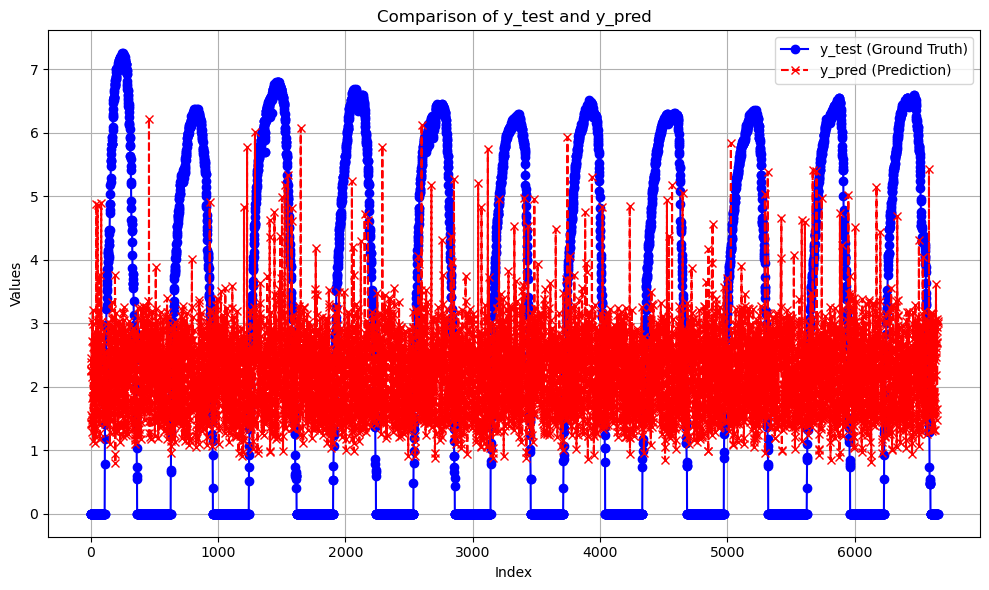

In [9]:
model_file_path = '/home/ubuntu/paper_arm_model/best_model/best_rf_model.joblib'
model = joblib.load(model_file_path)
if len(X_test.shape) > 2:
    X_test = X_test.reshape(X_test.shape[0], window_size * 12)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)
print(r2)
import numpy as np
import matplotlib.pyplot as plt



plt.figure(figsize=(10, 6))
plt.plot(y_test, label='y_test (Ground Truth)', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='y_pred (Prediction)', marker='x', linestyle='--', color='red')


plt.title('Comparison of y_test and y_pred')
plt.xlabel('Index')
plt.ylabel('Values')


plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()
